<a href="https://colab.research.google.com/github/robinhester/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/Permutation_Boosting_LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [0]:
import pandas as pd 

In [0]:
got=pd.read_csv('https://raw.githubusercontent.com/robinhester/DS-Unit-2-Applied-Modeling/master/data/gameofthrones.csv')

In [0]:
def data_wrangle(X):
  X=X.copy()

  duplicate=['Unnamed: 0', 'S.No', 'actual', 
             'pred', 'alive', 'plod']

  X=X.drop(columns=duplicate)

  X=X.fillna('Missing')

  leakage=['DateoFdeath', 'book1', 'book2', 
           'book3', 'book4','book5']

  X=X.drop(columns=leakage)

  top7houses=["Night's Watch", 'House Frey','House Stark',
              'House Stark','House Targaryen','House Lannister',
              'House Greyjoy','House Tyrell']

  X.loc[~X['house'].isin(top7houses),'house']== 'Other'

  top5=['Ser','Maester','Archmaester','Lord',
        'Septon','Winterfell','Missing']

  X.loc[~X['title'].isin(top5),'title']=='Other'
  X.title.replace('Missing','No Title')

  X['Female']=X.male == 0
  X.male.replace(1, 'True')
  X.male.replace(0,'False')

  X.isAliveMother.replace(1,'True')
  X.isAliveMother.replace(0,'False')

  X.isAliveFather.replace(1,'True')
  X.isAliveFather.replace(0,'False')

  X.isAliveHeir.replace(1,'True')
  X.isAliveHeir.replace(0,'False')

  X.isAliveSpouse.replace(1,'True')
  X.isAliveSpouse.replace(0,'False')

  X.isMarried.replace(1,'True')
  X.isMarried.replace(0,'False')

  X.isNoble.replace(1,'True')
  X.isNoble.replace(0,'False')

  return X

In [0]:
from sklearn.model_selection import train_test_split
train=got.copy()
train, test = train_test_split(train, train_size=.80, test_size=.20, 
                              stratify=train['isAlive'], random_state=42)

train, val = train_test_split(train, test_size=len(test), 
                              stratify=train['isAlive'], random_state=42)

In [5]:
train.shape, val.shape, test.shape

((1166, 34), (390, 34), (390, 34))

In [7]:
!pip install category_encoders

     |████████████████████████████████| 102kB 3.7MB/s 


In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [0]:
train=data_wrangle(train)
val=data_wrangle(val)
test=data_wrangle(test)

In [11]:
train.shape, val.shape, test.shape

((1166, 23), (390, 23), (390, 23))

In [12]:
target='isAlive'
features= train.drop(columns=[target]).columns
# print(features)
x_train=train[features]
y_train=train[target]
# y_train
x_val=val[features]
y_val=val[target]
#x_test
x_test=test[features]
y_test=test[target]

pipeline=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=3)
)
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
print('Train Accuracy:', pipeline.score(x_train,y_train))
print('Accuracy Score:', pipeline.score(x_val,y_val))

Train Accuracy: 0.7735849056603774
Accuracy Score: 0.7615384615384615


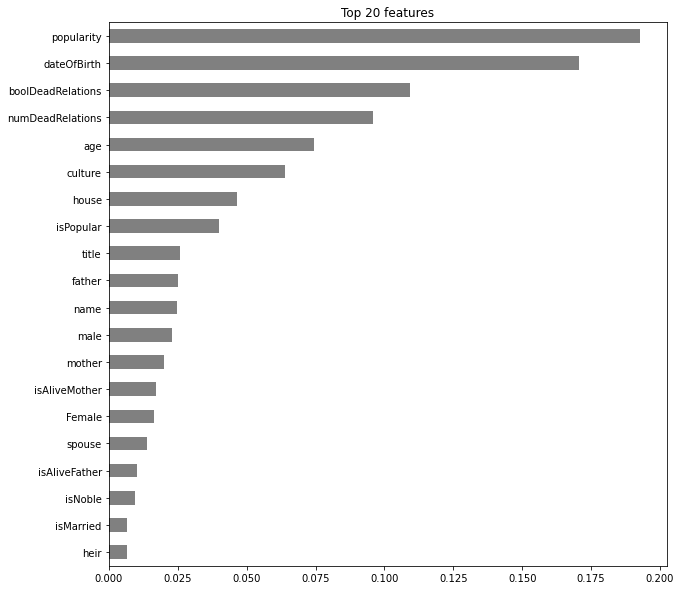

In [14]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, x_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [15]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median') 
)

x_train_transformed = transformers.fit_transform(x_train)
x_val_transformed = transformers.transform(x_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(x_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [17]:
!pip install eli5

     |████████████████████████████████| 112kB 4.8MB/s 


In [18]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(x_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [20]:
feature_names = x_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

male                -0.008718
Female              -0.005128
house               -0.002051
title               -0.001538
isNoble             -0.001026
culture             -0.000513
boolDeadRelations   -0.000513
spouse              -0.000513
isMarried            0.000000
isAliveHeir          0.000000
name                 0.000000
heir                 0.000000
mother               0.000000
father               0.000513
isAliveMother        0.000513
isAliveFather        0.001026
isAliveSpouse        0.001538
numDeadRelations     0.003077
isPopular            0.004615
dateOfBirth          0.031282
popularity           0.034359
age                  0.036923
dtype: float64

In [21]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0369 ± 0.0204,age
0.0344 ± 0.0333,popularity
0.0313 ± 0.0211,dateOfBirth
0.0046 ± 0.0119,isPopular
0.0031 ± 0.0088,numDeadRelations
0.0015 ± 0.0041,isAliveSpouse
0.0010 ± 0.0025,isAliveFather
0.0005 ± 0.0021,isAliveMother
0.0005 ± 0.0021,father
0 ± 0.0000,mother


In [0]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance

features = x_train.columns[mask]
x_train = x_train[features]

In [24]:
x_val = x_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(x_train, y_train)
print('Validation Accuracy', pipeline.score(x_val, y_val))

Validation Accuracy 0.7461538461538462


In [25]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(x_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(x_val)
print ('Validation accuracy', accuracy_score(y_val, y_pred))

Validation accuracy 0.7717948717948718


In [29]:
#previous was .71184
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(x_val)[:, -1]
roc_auc_score(y_val, y_pred_proba)

0.7136832239925024

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
(fpr, tpr, thresholds)

(array([0.        , 0.01010101, 0.01010101, 0.02020202, 0.02020202,
        0.04040404, 0.04040404, 0.05050505, 0.06060606, 0.06060606,
        0.08080808, 0.08080808, 0.09090909, 0.09090909, 0.09090909,
        0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
        0.09090909, 0.09090909, 0.09090909, 0.1010101 , 0.11111111,
        0.12121212, 0.12121212, 0.12121212, 0.12121212, 0.21212121,
        0.21212121, 0.22222222, 0.22222222, 0.23232323, 0.23232323,
        0.24242424, 0.24242424, 0.25252525, 0.25252525, 0.26262626,
        0.26262626, 0.28282828, 0.32323232, 0.32323232, 0.33333333,
        0.33333333, 0.34343434, 0.43434343, 0.43434343, 0.46464646,
        0.47474747, 0.51515152, 0.53535354, 0.54545455, 0.54545455,
        0.55555556, 0.55555556, 0.56565657, 0.57575758, 0.5959596 ,
        0.60606061, 0.62626263, 0.62626263, 0.64646465, 0.74747475,
        0.75757576, 0.75757576, 0.78787879, 0.78787879, 0.80808081,
        0.80808081, 0.81818182, 0.81818182, 0.82

Text(0, 0.5, 'True Positive Rate')

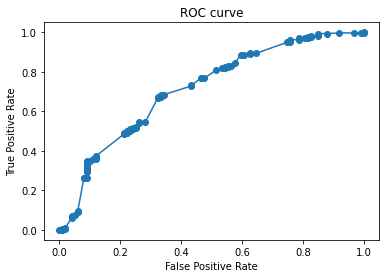

In [31]:
import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')